# Different segmentation workflows

This notebook walks you through the different segmentation workflows currently implemented in scPortrait using the same input example. Each segmentation workflow needs to be implemented in a seperate scPortrait project as the segmentation mask is the starting point for all further downstream steps.


In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

from scportrait.data._datasets import dataset_3
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define input images
path = dataset_3()
images = [
    f"{path}/Ch1.tif",
    f"{path}/Ch2.tif",
    f"{path}/Ch3.tif",
]

project_directory = "../../../example_data/example_3/segmentation_workflows"

Downloading...: 100%|██████████| 893k/893k [00:00<00:00, 2.63MB/s]


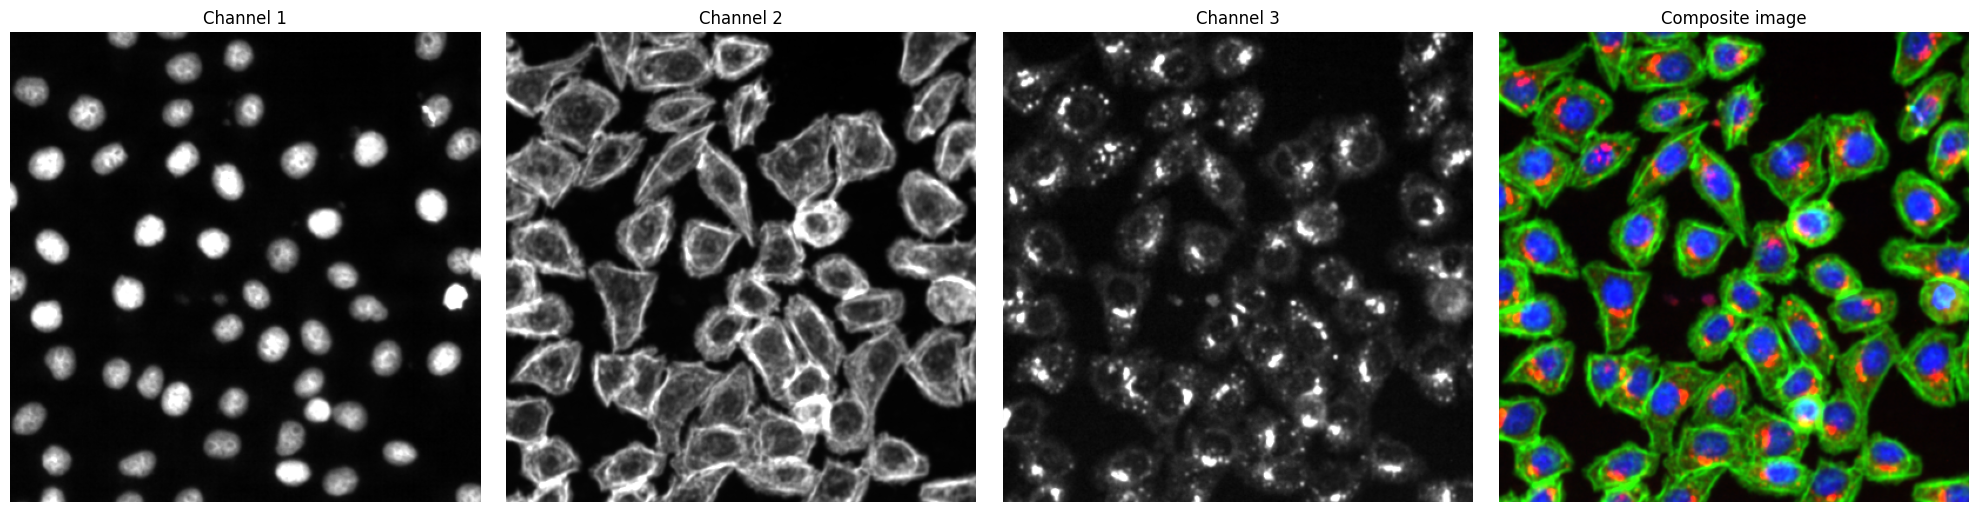

In [3]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

# read input image to visualize as an example
image = np.array([tifffile.imread(img) for img in images])

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, _img in enumerate(image):
    axs[i].imshow(_img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Channel {i+1}")

# also plot and visualize input image
img = generate_composite(image)

axs[3].imshow(img)
axs[3].axis("off")
axs[3].set_title("Composite image")

fig.tight_layout()

## WGA Segmentation

This segmentation workflow aims to segment mononucleated cells. Based on a nuclear and cytosolic stain, it first uses a thresholding approach to identify nuclei which are assumed to be the center of each cell. Then in a second step, the center of the identified nuclei are used as a starting point to generate a potential map using the cytosolic stain. This potential map is then used to segment the cytosol using a watershed approach. At the end of the workflow the user obtains both a nuclear and a cytosolic segmentation mask where each cytosol is matched to exactly one nucleus as kann be identified by the matching ``cell id``. 

The configuration file for the WGASegmentation method contains many parameters that need to be optimized for your particular dataset. Here is an example configuration:

    WGASegmentation:
    input_channels: 3
    chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
    cache: "."
    lower_quantile_normalization:   0.001
    upper_quantile_normalization:   0.999
    median_filter_size:   4 # Size in pixels
    nucleus_segmentation:
        lower_quantile_normalization:   0.01 # quantile normalization of dapi channel before local tresholding. Strong normalization (0.05,0.95) can help with nuclear speckles.
        upper_quantile_normalization:   0.99 # quantile normalization of dapi channel before local tresholding. Strong normalization (0.05,0.95) can help with nuclear speckles.
        median_block: 41 # Size of pixel disk used for median, should be uneven
        median_step: 4
        threshold: 0.2 # threshold above local median for nuclear segmentation
        speckle_kernel: 9 # Erosion followed by Dilation to remove speckels, size in pixels, should be uneven
        peak_footprint: 7 # 
        min_distance: 8 # minimum distance between two nucleis in pixel
        dilation: 0 # final dilation of pixel mask       
        min_size: 200 # minimum nucleus area in pixel
        max_size: 5000 # maximum nucleus area in pixel
        contact_filter: 0.5 # minimum nucleus contact with background
    cytosol_segmentation:
        threshold: 0.15 # treshold above which cytosol is detected
        lower_quantile_normalization: 0.01
        upper_quantile_normalization: 0.99
        erosion: 2 # erosion and dilation are used for speckle removal and shrinking / dilation
        dilation: 7 # for no change in size choose erosion = dilation, for larger cells increase the mask erosion
        min_clip: 0
        max_clip: 0.2
        min_size: 200
        max_size: 30000
    chunk_size: 50
    filter_masks_size: True

In [4]:
from scportrait.pipeline.segmentation.workflows import WGASegmentation

project_location = f"{project_directory}/WGASegmentation"

project = Project(
    os.path.abspath(project_location),
    config_path="../../../example_data/example_3/config_example3.yml",
    overwrite=True,
    debug=False,
    segmentation_f=WGASegmentation,
    extraction_f=HDF5CellExtraction,
)


project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/WGASegmentation/sc
         portrait.sdata                                                                                            
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/WGASegmentation/sc
         portrait.sdata                                                                                            


In [5]:
project.segment()
project.extract()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Channels shape:  (2, 399, 399)


Processing cell batches: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


multiprocessing done.


### Segmentation Results

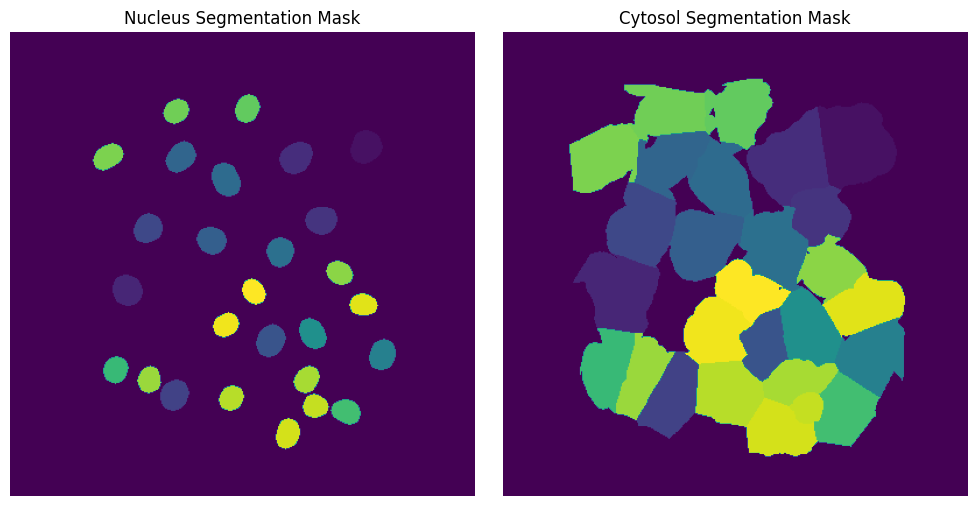

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(project.sdata["seg_all_nucleus"])
axs[0].axis("off")
axs[0].set_title("Nucleus Segmentation Mask")

axs[1].imshow(project.sdata["seg_all_cytosol"])
axs[1].axis("off")
axs[1].set_title("Cytosol Segmentation Mask")
fig.tight_layout()

### Extraction Results

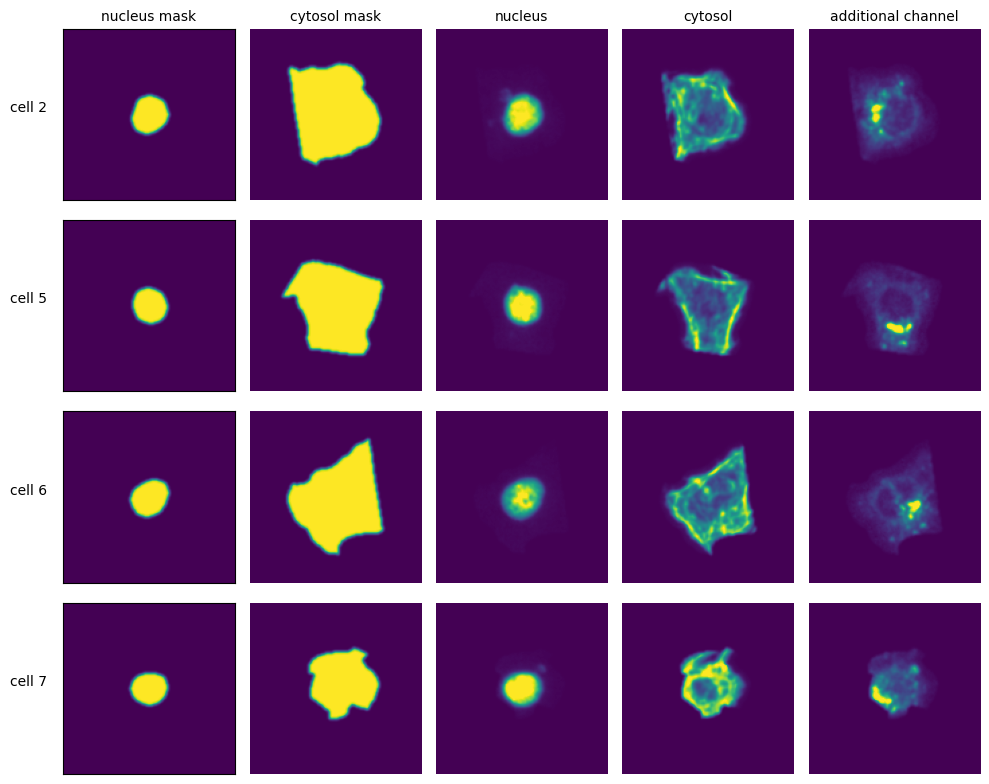

In [7]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize=(5 * 2, n_cells * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

## DAPI Segmentation

This segmentation workflow aims to only segment the nuclei of cells. It uses the same nuclear segmentation method as the WGASegmentation. Here is an example configuration:

    DAPISegmentation:
        input_channels: 3
        chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
        cache: "."
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size:   4 # Size in pixels
        nucleus_segmentation:
            lower_quantile_normalization:   0.01 # quantile normalization of dapi channel before local tresholding. Strong normalization (0.05,0.95) can help with nuclear speckles.
            upper_quantile_normalization:   0.99 # quantile normalization of dapi channel before local tresholding. Strong normalization (0.05,0.95) can help with nuclear speckles.
            median_block: 41 # Size of pixel disk used for median, should be uneven
            median_step: 4
            threshold: 0.2 # threshold above local median for nuclear segmentation
            min_distance: 8 # minimum distance between two nucleis in pixel
            peak_footprint: 7 # 
            speckle_kernel: 9 # Erosion followed by Dilation to remove speckels, size in pixels, should be uneven
            dilation: 0 # final dilation of pixel mask       
            min_size: 200 # minimum nucleus area in pixel
            max_size: 5000 # maximum nucleus area in pixel
            contact_filter: 0.5 # minimum nucleus contact with background
        chunk_size: 50
        filter_masks_size: False

In [8]:
from scportrait.pipeline.segmentation.workflows import DAPISegmentation

project_location = f"{project_directory}/DAPISegmentation"

project = Project(
    os.path.abspath(project_location),
    config_path="../../../example_data/example_3/config_example3.yml",
    overwrite=True,
    debug=False,
    segmentation_f=DAPISegmentation,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/DAPISegmentation/s
         cportrait.sdata                                                                                           
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/DAPISegmentation/s
         cportrait.sdata                                                                                           


In [9]:
project.segment()
project.extract()

Processing cell batches: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


multiprocessing done.


### Segmentation Results

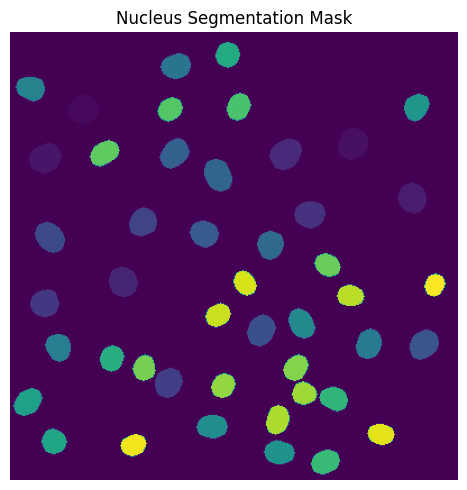

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(project.sdata["seg_all_nucleus"])
axs.axis("off")
axs.set_title("Nucleus Segmentation Mask")
fig.tight_layout()

### Extraction Results

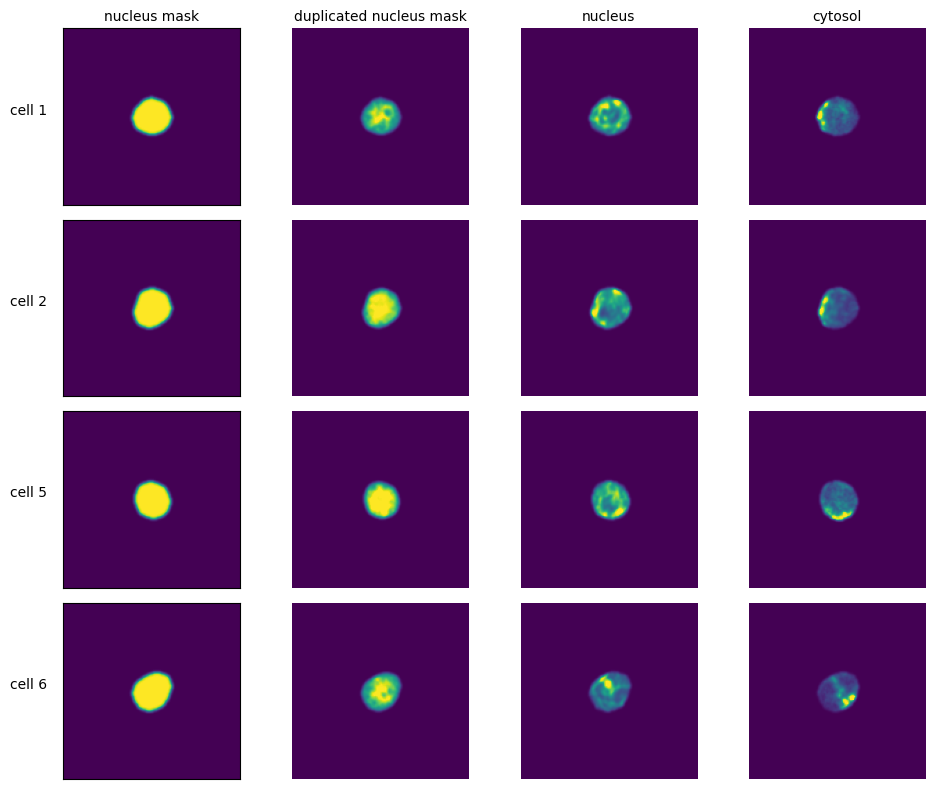

In [11]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 4, figsize=(5 * 2, n_cells * 2))
    labels = ["nucleus mask", "duplicated nucleus mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

## Cytosol Segmentation Cellpose

This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow. During this segmentation workflow two different cellpose models are run. The first is used to segment the nuclei and the second one is used to segment the cytosols. Afterwards the IDs in the nucleus and cytosol mask are matched together.

Here is an example configuration:

    CytosolSegmentationCellpose:
        input_channels: 2
        output_masks: 2
        shard_size: 120000000 # maxmimum number of pixel per tile
        overlap_px: 100
        nGPUs: 1
        chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
        threads: 1 # number of shards / tiles segmented at the same size. should be adapted to the maximum amount allowed by memory.
        cache: "."
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size: 6 # Size in pixels
        nucleus_segmentation:
            model: "nuclei"
        cytosol_segmentation:
            model: "cyto2"
        chunk_size: 50
        match_masks: True
        filtering_threshold_mask_matching: 0.95
        filter_masks_size: False

In [12]:
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose

project_location = f"{project_directory}/CytosolSegmentationCellpose"

project = Project(
    os.path.abspath(project_location),
    config_path="../../../example_data/example_3/config_example3.yml",
    overwrite=True,
    debug=False,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/CytosolSegmentatio
         nCellpose/scportrait.sdata                                                                                
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/CytosolSegmentatio
         nCellpose/scportrait.sdata                                                                                


In [13]:
project.segment()
project.extract()

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
Processing cell batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


multiprocessing done.


### Segmentation Results

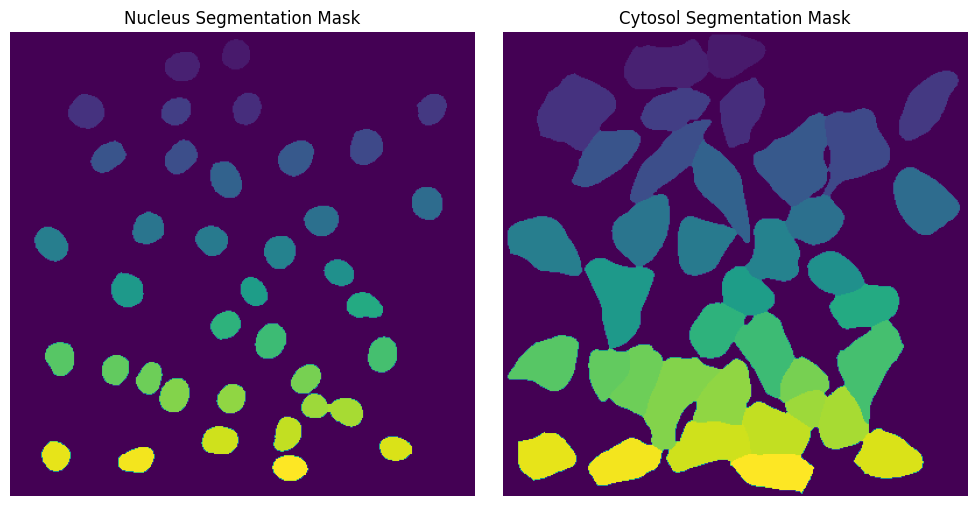

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(project.sdata["seg_all_nucleus"])
axs[0].axis("off")
axs[0].set_title("Nucleus Segmentation Mask")

axs[1].imshow(project.sdata["seg_all_cytosol"])
axs[1].axis("off")
axs[1].set_title("Cytosol Segmentation Mask")

fig.tight_layout()

### Extraction Results

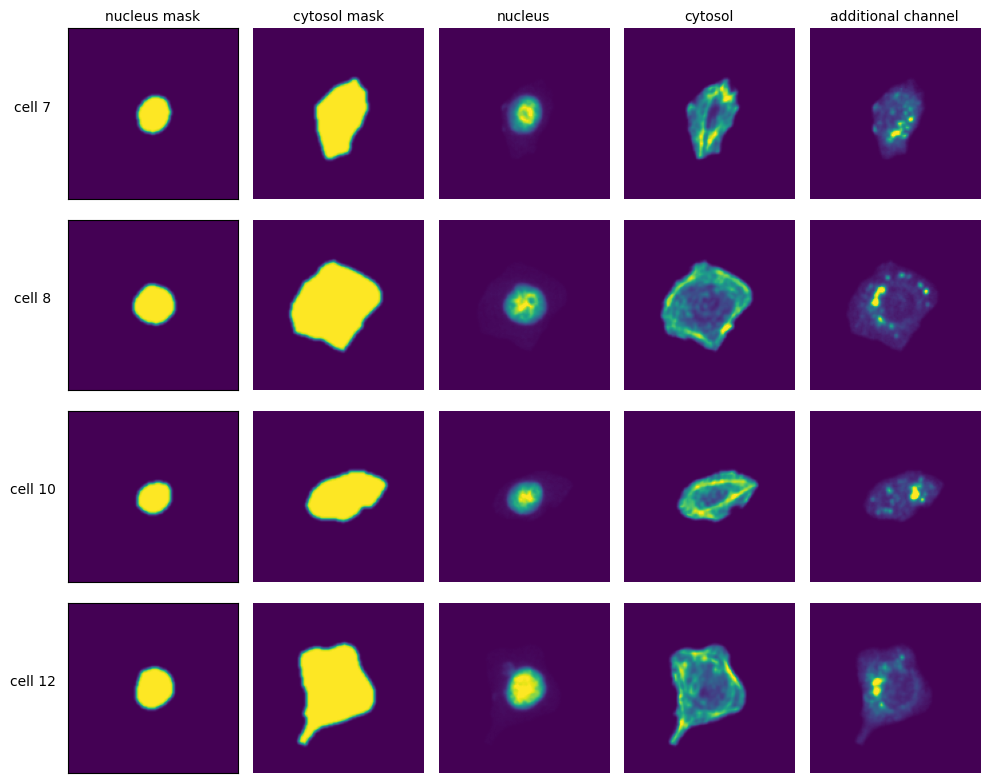

In [15]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize=(5 * 2, n_cells * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

## DAPI Segmentation Cellpose

This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow. It only performs a nuclear segmentation using one cellpose model. 

Here is an example configuration:

    DAPISegmentationCellpose:
        input_channels: 2
        output_masks: 2
        shard_size: 120000000 # maxmimum number of pixel per tile
        overlap_px: 100
        nGPUs: 1
        chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
        threads: 1 # number of shards / tiles segmented at the same size. should be adapted to the maximum amount allowed by memory.
        cache: "."
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size: 6 # Size in pixels
        nucleus_segmentation:
            model: "nuclei"
        chunk_size: 50
        filter_masks_size: False

In [16]:
from scportrait.pipeline.segmentation.workflows import DAPISegmentationCellpose

project_location = f"{project_directory}/DAPISegmentationCellpose"

project = Project(
    os.path.abspath(project_location),
    config_path="../../../example_data/example_3/config_example3.yml",
    overwrite=True,
    debug=False,
    segmentation_f=DAPISegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/DAPISegmentationCe
         llpose/scportrait.sdata                                                                                   
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/example_data/example_3/segmentation_workflows/DAPISegmentationCe
         llpose/scportrait.sdata                                                                                   


In [17]:
project.segment()
project.extract()

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
Processing cell batches: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


multiprocessing done.


### Segmentation Results

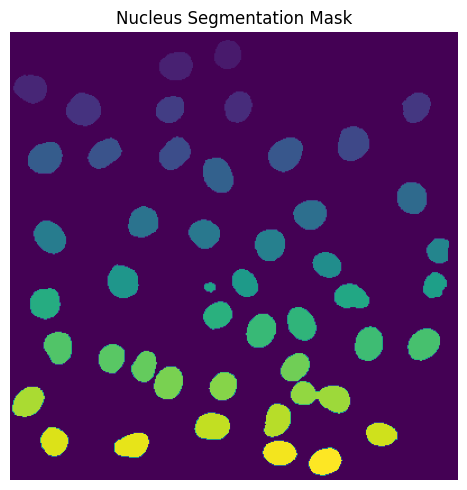

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(project.sdata["seg_all_nucleus"])
axs.axis("off")
axs.set_title("Nucleus Segmentation Mask")

fig.tight_layout()

### Extraction Results

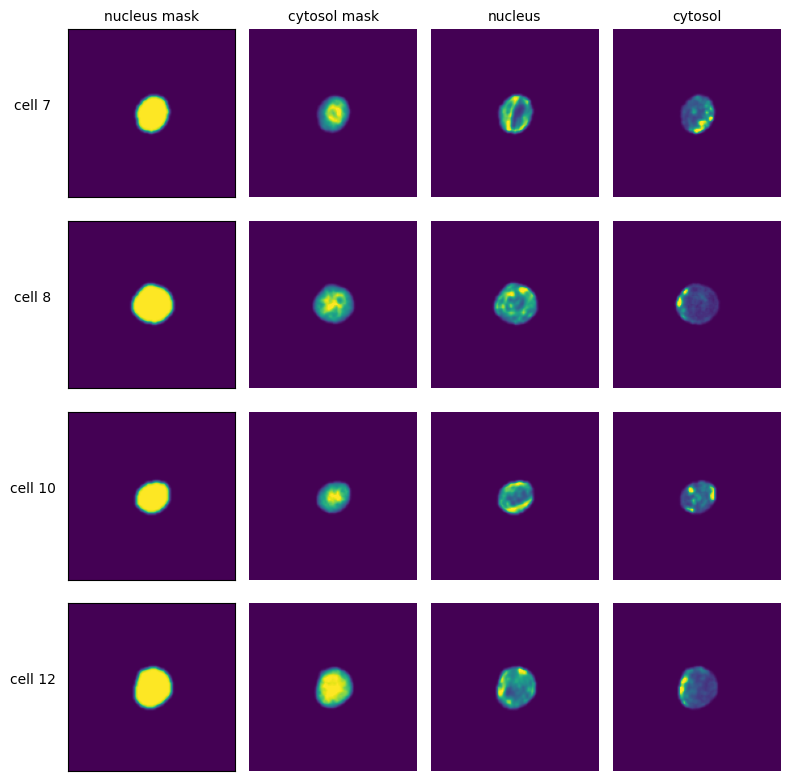

In [19]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 4, figsize=(4 * 2, n_cells * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()